In [1]:
import pandas as pd
from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import regex
from itertools import combinations
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)


In [2]:
data = pd.read_parquet("../results/dhd-corpus.parquet")
data.cities = data.cities.str.split("; ").map(lambda x: [e for e in x if e != ""])
data=data[data.cities.map(lambda x: x!=[])]
data.topics=data.topics.map(lambda x: x.split("; ") if isinstance(x, str) else x)
data.cities.to_list()

[['Bochum', 'Berlin'],
 ['Dortmund', 'Berlin', 'Dortmund', 'Dortmund'],
 ['Stuttgart', 'Stuttgart'],
 ['Wien'],
 ['Trier', 'Marbach', 'Halle-Wittenberg'],
 ['Gießen', 'Gießen', 'Gießen', 'Gießen'],
 ['Gießen', 'Gießen', 'Gießen', 'Gießen'],
 ['Hannover', 'Göttingen', 'Trier', 'Hamburg'],
 ['Regensburg', 'Regensburg', 'Regensburg', 'Regensburg'],
 ['Heidelberg', 'Heidelberg', 'Heidelberg', 'Heidelberg'],
 ['Konstanz',
  'Konstanz',
  'Konstanz',
  'Konstanz',
  'Konstanz',
  'Konstanz',
  'Konstanz',
  'Konstanz'],
 ['Frankfurt'],
 ['Karlsruhe', 'Trier', 'Darmstadt', 'Darmstadt', 'Trier'],
 ['Frankfurt', 'Frankfurt', 'Frankfurt', 'Frankfurt', 'Frankfurt'],
 ['Salzburg', 'Salzburg', 'Salzburg'],
 ['Halle-Wittenberg', 'Halle-Wittenberg', 'Halle-Wittenberg'],
 ['Wien', 'Wien', 'Wien'],
 ['Bochum', 'Bochum'],
 ['Tübingen', 'Potsdam', 'Berlin'],
 ['Bergen'],
 ['Duisburg'],
 ['Berlin'],
 ['Braunschweig',
  'Braunschweig',
  'Braunschweig',
  'Wolfenbüttel',
  'Wolfenbüttel'],
 ['Mannheim', 'M

### How many publications have at least one author of a specific city?

In [3]:
city_frequency_overall = data.cities.map(lambda x: list(set(x))).explode().value_counts()
city_frequency_overall.to_excel("../results/city_frequency_overall.xlsx")
city_frequency_overall

Berlin                155
Wien                   89
Würzburg               85
Köln                   81
Göttingen              70
Hamburg                68
Stuttgart              62
Leipzig                62
Graz                   62
Potsdam                58
Darmstadt              57
München                49
Mainz                  47
Trier                  44
Paderborn              34
Frankfurt              33
Wolfenbüttel           30
Erlangen               29
Heidelberg             26
Dresden                25
Regensburg             25
Halle-Wittenberg       23
Bonn                   22
Mannheim               20
Marburg                20
Tübingen               20
Jena                   17
Passau                 17
Bochum                 17
Zürich                 16
Karlsruhe              15
Essen                  14
Bamberg                13
Wuppertal              13
Moskau                 13
Paris                  12
Krems                  12
Münster                12
Bielefeld   

In [4]:
topk_cities = data.cities.map(lambda x: list(set(x))).explode().value_counts().index[:10]

### How many publications have at least one author of a specific city per year?

In [5]:
_tmp = data.copy()
_tmp.cities = _tmp.cities.map(lambda x: list(set(x)))

In [6]:
d = _tmp.groupby("year").cities.apply(lambda x: Counter(sum(x,[]))).unstack()
d.index.name = "Jahr"
d.columns.name = "Stadt"
d

Stadt  Bochum  Berlin  Dortmund  Stuttgart  Wien  Marbach  Halle-Wittenberg  \
Jahr                                                                          
2014      3.0     9.0       1.0        2.0   4.0      1.0               3.0   
2015      3.0    13.0       1.0        6.0  13.0      NaN               NaN   
2016      NaN    21.0       1.0        5.0  11.0      NaN               3.0   
2017      1.0    10.0       1.0        5.0   9.0      NaN               1.0   
2018      1.0    20.0       1.0       11.0  15.0      1.0               4.0   
2019      NaN    14.0       NaN        6.0  11.0      NaN               4.0   
2020      3.0    10.0       NaN       10.0   9.0      1.0               3.0   
2022      4.0    32.0       NaN       10.0  11.0      3.0               4.0   
2023      2.0    26.0       NaN        7.0   6.0      4.0               1.0   

Stadt  Trier  Gießen  Hannover  Hamburg  Göttingen  Regensburg  Heidelberg  \
Jahr                                                                         
2014     7.0     3.0       2.0      7.0        5.0         1.0         4.0   
2015     4.0     1.0       1.0      5.0        6.0         2.0         7.0   
2016     5.0     3.0       1.0      8.0       13.0         2.0         4.0   
2017     1.0     2.0       NaN      5.0        9.0         2.0         NaN   
2018     5.0     NaN       NaN      7.0        9.0         4.0         2.0   
2019     NaN     NaN       NaN     10.0        8.0         3.0         3.0   
2020     2.0     NaN       NaN     12.0        1.0         2.0         3.0   
2022     8.0     NaN       3.0      6.0        7.0         5.0         2.0   
2023    12.0     NaN       1.0      8.0       12.0         4.0         1.0   

Stadt  Konstanz  Frankfurt  Karlsruhe  Darmstadt  Salzburg  Tübingen  Potsdam  \
Jahr                                                                            
2014        1.0        3.0        2.0        4.0       2.0       5.0      1.0   
2015        NaN        5.0        1.0        2.0       NaN       4.0      4.0   
2016        2.0        4.0        1.0        9.0       2.0       5.0      5.0   
2017        NaN        1.0        3.0        4.0       1.0       2.0      5.0   
2018        NaN        5.0        NaN        3.0       NaN       3.0      8.0   
2019        NaN        9.0        2.0        1.0       NaN       NaN      4.0   
2020        NaN        2.0        1.0        5.0       1.0       NaN      6.0   
2022        NaN        3.0        2.0       14.0       NaN       1.0     19.0   
2023        NaN        1.0        3.0       15.0       NaN       NaN      6.0   

Stadt  Bergen  Duisburg  Braunschweig  Wolfenbüttel  Mannheim  Bonn  Erlangen  \
Jahr                                                                            
2014      2.0       1.0           1.0           1.0       1.0   2.0       2.0   
2015      1.0       NaN           1.0           3.0       NaN   3.0       4.0   
2016      1.0       1.0           1.0           4.0       4.0   1.0       5.0   
2017      NaN       NaN           NaN           4.0       2.0   NaN       1.0   
2018      NaN       NaN           NaN           4.0       2.0   2.0       5.0   
2019      NaN       NaN           NaN           6.0       3.0   4.0       4.0   
2020      1.0       1.0           NaN           4.0       2.0   5.0       5.0   
2022      NaN       NaN           2.0           3.0       2.0   2.0       2.0   
2023      NaN       2.0           3.0           1.0       4.0   3.0       1.0   

Stadt  München  Leipzig  Passau  Hildesheim  Detmold  Essen  Lüneburg  Köln  \
Jahr                                                                          
2014       9.0      3.0     2.0         1.0      1.0    2.0       2.0   3.0   
2015       8.0      9.0     1.0         3.0      2.0    2.0       1.0   4.0   
2016       7.0     11.0     NaN         1.0      2.0    4.0       NaN   5.0   
2017       3.0      2.0     4.0         NaN      NaN    1.0       NaN   7.0   
2018       2.

<Axes: xlabel='Jahr', ylabel='Anzahl Publikationen'>

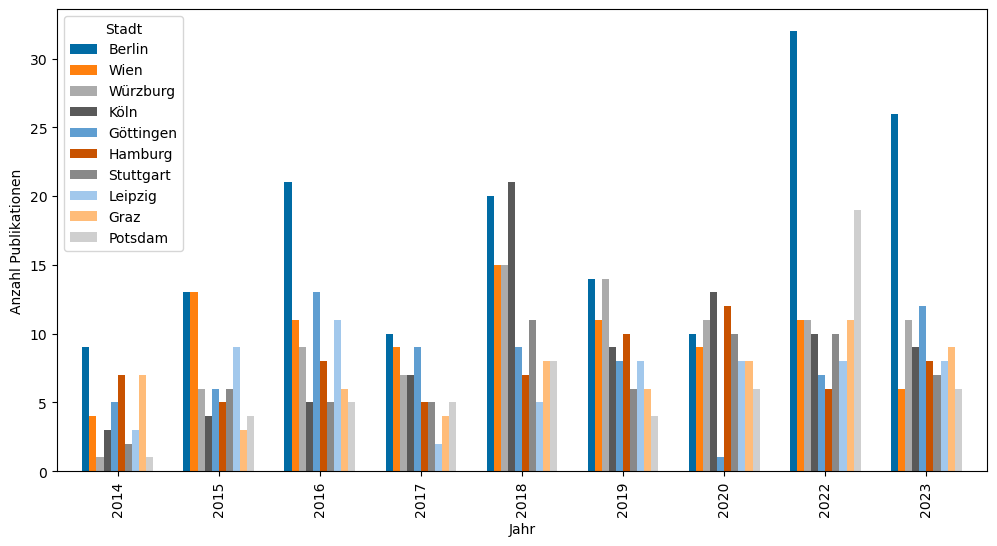

In [7]:
plt.ylabel = "Anzahl Publikationen"
plt.style.use('tableau-colorblind10')
d[topk_cities].plot(kind="bar", figsize=(12,6), ylabel="Anzahl Publikationen", width=0.7)


In [8]:
frequency = _tmp.groupby("year").cities.apply(lambda x: Counter(sum(x,[]))).unstack().fillna(0)
frequency["overall"] = frequency.sum(axis=1)
frequency.to_excel("../results/city-frequencies.xlsx")
frequency

Bochum  Berlin  Dortmund  Stuttgart  Wien  Marbach  Halle-Wittenberg  \
year                                                                         
2014     3.0     9.0       1.0        2.0   4.0      1.0               3.0   
2015     3.0    13.0       1.0        6.0  13.0      0.0               0.0   
2016     0.0    21.0       1.0        5.0  11.0      0.0               3.0   
2017     1.0    10.0       1.0        5.0   9.0      0.0               1.0   
2018     1.0    20.0       1.0       11.0  15.0      1.0               4.0   
2019     0.0    14.0       0.0        6.0  11.0      0.0               4.0   
2020     3.0    10.0       0.0       10.0   9.0      1.0               3.0   
2022     4.0    32.0       0.0       10.0  11.0      3.0               4.0   
2023     2.0    26.0       0.0        7.0   6.0      4.0               1.0   

      Trier  Gießen  Hannover  Hamburg  Göttingen  Regensburg  Heidelberg  \
year                                                                        
2014    7.0     3.0       2.0      7.0        5.0         1.0         4.0   
2015    4.0     1.0       1.0      5.0        6.0         2.0         7.0   
2016    5.0     3.0       1.0      8.0       13.0         2.0         4.0   
2017    1.0     2.0       0.0      5.0        9.0         2.0         0.0   
2018    5.0     0.0       0.0      7.0        9.0         4.0         2.0   
2019    0.0     0.0       0.0     10.0        8.0         3.0         3.0   
2020    2.0     0.0       0.0     12.0        1.0         2.0         3.0   
2022    8.0     0.0       3.0      6.0        7.0         5.0         2.0   
2023   12.0     0.0       1.0      8.0       12.0         4.0         1.0   

      Konstanz  Frankfurt  Karlsruhe  Darmstadt  Salzburg  Tübingen  Potsdam  \
year                                                                           
2014       1.0        3.0        2.0        4.0       2.0       5.0      1.0   
2015       0.0        5.0        1.0        2.0       0.0       4.0      4.0   
2016       2.0        4.0        1.0        9.0       2.0       5.0      5.0   
2017       0.0        1.0        3.0        4.0       1.0       2.0      5.0   
2018       0.0        5.0        0.0        3.0       0.0       3.0      8.0   
2019       0.0        9.0        2.0        1.0       0.0       0.0      4.0   
2020       0.0        2.0        1.0        5.0       1.0       0.0      6.0   
2022       0.0        3.0        2.0       14.0       0.0       1.0     19.0   
2023       0.0        1.0        3.0       15.0       0.0       0.0      6.0   

      Bergen  Duisburg  Braunschweig  Wolfenbüttel  Mannheim  Bonn  Erlangen  \
year                                                                           
2014     2.0       1.0           1.0           1.0       1.0   2.0       2.0   
2015     1.0       0.0           1.0           3.0       0.0   3.0       4.0   
2016     1.0       1.0           1.0           4.0       4.0   1.0       5.0   
2017     0.0       0.0           0.0           4.0       2.0   0.0       1.0   
2018     0.0       0.0           0.0           4.0       2.0   2.0       5.0   
2019     0.0       0.0           0.0           6.0       3.0   4.0       4.0   
2020     1.0       1.0           0.0           4.0       2.0   5.0       5.0   
2022     0.0       0.0           2.0           3.0       2.0   2.0       2.0   
2023     0.0       2.0           3.0           1.0       4.0   3.0       1.0   

      München  Leipzig  Passau  Hildesheim  Detmold  Essen  Lüneburg  Köln  \
year                                                                         
2014      9.0      3.0     2.0         1.0      1.0    2.0       2.0   3.0   
2015      8.0      9.0     1.0         3.0      2.0    2.0       1.0   4.0   
2016      7.0     11.0     0.0         1.0      2.0    4.0       0.0   5.0   
2017      3.0      2.0     4.0         0.0      0.0    1.0       0.0   7.0   
2018      2.0      5.0     5.0         2.0      0.0    1.0       0.0 

In [9]:
data.cities.map(lambda x: list(set(x)))

index
0                                                                       [Bochum, Berlin]
1                                                                     [Berlin, Dortmund]
2                                                                            [Stuttgart]
3                                                                                 [Wien]
4                                                     [Marbach, Halle-Wittenberg, Trier]
5                                                                               [Gießen]
6                                                                               [Gießen]
7                                                  [Hannover, Hamburg, Göttingen, Trier]
8                                                                           [Regensburg]
9                                                                           [Heidelberg]
10                                                                            [Konstanz]
11             

In [10]:
def _cp(x):
    return sum([list(e for e in combinations(set(city), 2) )  for city in x],[])
pairs = data.groupby(['year']).cities.apply(_cp)
cities = list(set(sum(_tmp.cities, [])))
cocityship = pd.DataFrame(index=cities, columns=cities).fillna(0).astype(int)

for (a1,a2) in sum(pairs,[]):
    cocityship.loc[a1, a2] += 1


## Most Frequent collaborations (At least one author from a city)

In [11]:
Counter(tuple(sorted(e)) for e in sum(pairs.to_list(),[]) if e[0] != e[1])

Counter({('Graz', 'Wien'): 17,
         ('Berlin', 'Potsdam'): 13,
         ('Berlin', 'Göttingen'): 11,
         ('Graz', 'Köln'): 9,
         ('Köln', 'Stuttgart'): 9,
         ('Berlin', 'Köln'): 9,
         ('Berlin', 'Mainz'): 9,
         ('Berlin', 'Leipzig'): 8,
         ('Darmstadt', 'Trier'): 7,
         ('Göttingen', 'Wolfenbüttel'): 7,
         ('Berlin', 'Wolfenbüttel'): 7,
         ('Berlin', 'Wien'): 7,
         ('Darmstadt', 'Köln'): 7,
         ('Berlin', 'Tübingen'): 6,
         ('Darmstadt', 'Marburg'): 6,
         ('Dresden', 'Leipzig'): 6,
         ('Berlin', 'Rom'): 6,
         ('Dresden', 'Würzburg'): 6,
         ('Moskau', 'Potsdam'): 6,
         ('Berlin', 'Darmstadt'): 6,
         ('Graz', 'Potsdam'): 6,
         ('Potsdam', 'Wien'): 6,
         ('Köln', 'Potsdam'): 6,
         ('Berlin', 'Graz'): 6,
         ('Darmstadt', 'Hamburg'): 6,
         ('Darmstadt', 'Karlsruhe'): 5,
         ('Dresden', 'Marburg'): 5,
         ('Göttingen', 'Köln'): 5,
         ('Ber

In [12]:
G = nx.from_pandas_adjacency(cocityship).to_undirected()
nx.write_gexf(G, "../results/cocityship.gexf")
cocityship.to_excel("../results/cocityship.xlsx")

In [13]:

cocityship

Sheffield  Ormskirk  Santa Barbara  Cork  Rostock  Bochum  \
Sheffield                   0         0              0     1        0       0   
Ormskirk                    0         0              0     0        0       0   
Santa Barbara               0         0              0     0        0       0   
Cork                        0         0              0     0        0       0   
Rostock                     0         0              0     0        0       0   
Bochum                      0         0              0     0        0       0   
Oslo                        0         0              0     0        0       0   
Frankfurt am Main           0         0              0     0        0       0   
Potsdam                     1         0              0     0        0       0   
Augsburg                    0         0              0     0        0       0   
Zagreb                      0         0              0     0        0       0   
Antwerpen                   0         0              0     0        0       0   
Kiel                        0         0              0     0        0       0   
Fairfax                     0         0              0     0        0       1   
Cottbus                     0         0              0     0        0       0   
Edinburgh                   0         0              0     0        0       0   
Frankfurt                   0         0              0     0        0       0   
Freiburg                    0         0              0     0        0       0   
Klagenfurt                  0         0              0     0        0       0   
Linköping                   0         0              0     0        0       1   
Mailand                     0         0              0     0        0       0   
Köln                        0         0              0     0        0       0   
Krems                       0         0              0     0        0       1   
Groningen                   0         0              0     0        0       0   
Heidelberg                  0         0              0     0        0       0   
Illinois                    0         0              0     0        0       0   
Duisburg                    0         0              0     0        0       0   
Jerusalem                   0         0              0     0        0       1   
Le Mans                     0         0              0     0        0       0   
Kassel                      0         0              0     0        0       0   
Detmold                     0         0              0     0        0       0   
Basel                       0         0              0     0        0       0   
Eichstätt                   0         0              0     0        0       0   
Delft, Netherlands          0         0              0     0        0       0   
Verona                      0         0              0     0        0       0   
München                     0         0              0     0        0       0   
Trier                       0         0              0     0        0       0   
Tübingen                    0         0              0     0        0       0   
Lausanne                    0         0              0     0        0       0   
Hagen, Germany              0         0              0     0        0       0   
Krakau                      0         0              0     0        0       0   
Budapest                    0         0              0     0        0       0   
Washington                  0         0              0     0        0       0   
Berlin                      0         0              0     0        0       1   
Oxford Uk                   0         0              0     0        0       0   
Dresden                     0         0              0     0        0       0   
Hildesheim                  0         0              0     0        0       0   
Innsbruck                   0         0              0     0        0       0   
Athens                      0         0            

## Communities and Cliques

In [14]:

def merge(lsts):
    sets = [set(lst) for lst in lsts if lst]
    merged = True
    while merged:
        merged = False
        results = []
        while sets:
            common, rest = sets[0], sets[1:]
            sets = []
            for x in rest:
                if x.isdisjoint(common):
                    sets.append(x)
                else:
                    merged = True
                    common |= x
            results.append(common)
        sets = results
    return sets
communities = [x for x in nx.community.louvain_communities(G)]
merge(communities)

[{'Bochum',
  'Dortmund',
  'Düsseldorf',
  'Erfurt',
  'Fairfax',
  'Jerusalem',
  'Linköping',
  'Magdeburg',
  'Milton Keynes',
  'Ormskirk'},
 {'Amsterdam',
  'Bern',
  'Freiburg',
  'Hamburg',
  'Heidelberg',
  'Köln',
  'Mannheim',
  'Münster',
  'Saarbrücken',
  'Stuttgart',
  'Utrecht',
  'Wuppertal'},
 {'Illinois'},
 {'Athens',
  'Beijing',
  'Budapest',
  'Cork',
  'Eichstätt',
  'Glasgow',
  'Graz',
  'Krems',
  'London',
  'Luzern',
  'Mailand',
  'Marbach',
  'Moscow',
  'Moskau',
  'Odense',
  'Oxford Uk',
  'Potsdam',
  'Salamanca',
  'Sheffield',
  'Weimar',
  'Wien',
  'Zagreb'},
 {'Osnabrück'},
 {'Lausanne', 'Paderborn', 'Rostock'},
 {'Groningen', 'Passau', 'St. Gallen'},
 {'Bozen'},
 {'Bamberg',
  'Berlin',
  'Bonn',
  'Detmold',
  'Duisburg',
  'Erlangen',
  'Essen',
  'Göttingen',
  'Kopenhagen',
  'Le Mans',
  'Lissabon',
  'Lüneburg',
  'Mainz',
  'Melbourne',
  'Oslo',
  'Paris',
  'Rom',
  'Salzburg',
  'Santa Barbara',
  'Tübingen',
  'Uppsala',
  'Wolfenbütte

In [15]:
cliques = list(nx.find_cliques(G))
cliques

[['Verona', 'Basel'],
 ['Bozen'],
 ['Beijing', 'Frankfurt', 'Wien'],
 ['Sheffield', 'Glasgow', 'Cork'],
 ['Sheffield', 'Moskau', 'Wien', 'Saarbrücken'],
 ['Sheffield', 'Moskau', 'Wien', 'Potsdam'],
 ['Santa Barbara', 'Mainz', 'Paris'],
 ['Ormskirk', 'Milton Keynes'],
 ['Amsterdam', 'Wolfenbüttel', 'Utrecht', 'Wuppertal', 'Köln'],
 ['Lausanne', 'Zürich', 'Rostock', 'Wien'],
 ['Lausanne', 'Zürich', 'Trier', 'Luxembourg'],
 ['Lausanne', 'Zürich', 'Trier', 'Göttingen', 'Mainz'],
 ['Lausanne', 'Zürich', 'Trier', 'Göttingen', 'Wien'],
 ['Budapest', 'Potsdam', 'Mailand', 'London', 'Athens'],
 ['Krakau', 'Würzburg'],
 ['Jodhpur, Indien'],
 ['Kaiserslautern'],
 ['Oldenburg'],
 ['Berlin', 'Trier', 'Köln', 'Bielefeld', 'Darmstadt', 'Mainz', 'Münster'],
 ['Berlin', 'Trier', 'Köln', 'Bielefeld', 'Darmstadt', 'Würzburg', 'Marburg'],
 ['Berlin', 'Trier', 'Köln', 'Bochum', 'Mainz', 'Essen', 'Bonn'],
 ['Berlin', 'Trier', 'Köln', 'Bochum', 'Mainz', 'Hamburg'],
 ['Berlin', 'Trier', 'Köln', 'Bochum', 'Wür

#### Cliques seem to be everywhere. If merged by intersection, the DH-city-graph becomes one big community :)
(No separate communities)

In [16]:
merge(cliques)

[{'Amsterdam',
  'Antwerpen',
  'Athens',
  'Augsburg',
  'Bamberg',
  'Basel',
  'Beijing',
  'Bergen',
  'Berlin',
  'Bern',
  'Bielefeld',
  'Bochum',
  'Bologna',
  'Bonn',
  'Braunschweig',
  'Bremen',
  'Budapest',
  'Cambridge',
  'Cork',
  'Cottbus',
  'Darmstadt',
  'Delft, Netherlands',
  'Detmold',
  'Dortmund',
  'Dresden',
  'Duisburg',
  'Düsseldorf',
  'Edinburgh',
  'Eichstätt',
  'Erfurt',
  'Erlangen',
  'Essen',
  'Fairfax',
  'Frankfurt',
  'Frankfurt am Main',
  'Freiburg',
  'Gießen',
  'Glasgow',
  'Graz',
  'Greifswald',
  'Groningen',
  'Göttingen',
  'Hagen, Germany',
  'Halle-Wittenberg',
  'Hamburg',
  'Hannover',
  'Heidelberg',
  'Hildesheim',
  'Innsbruck',
  'Jena',
  'Jerusalem',
  'Karlsruhe',
  'Kassel',
  'Kiel',
  'Klagenfurt',
  'Koblenz',
  'Konstanz',
  'Kopenhagen',
  'Krakau',
  'Krems',
  'Köln',
  'Lausanne',
  'Le Mans',
  'Leipzig',
  'Linköping',
  'Lissabon',
  'London',
  'Luxembourg',
  'Luzern',
  'Lyon',
  'Lüneburg',
  'Magdeburg',
 

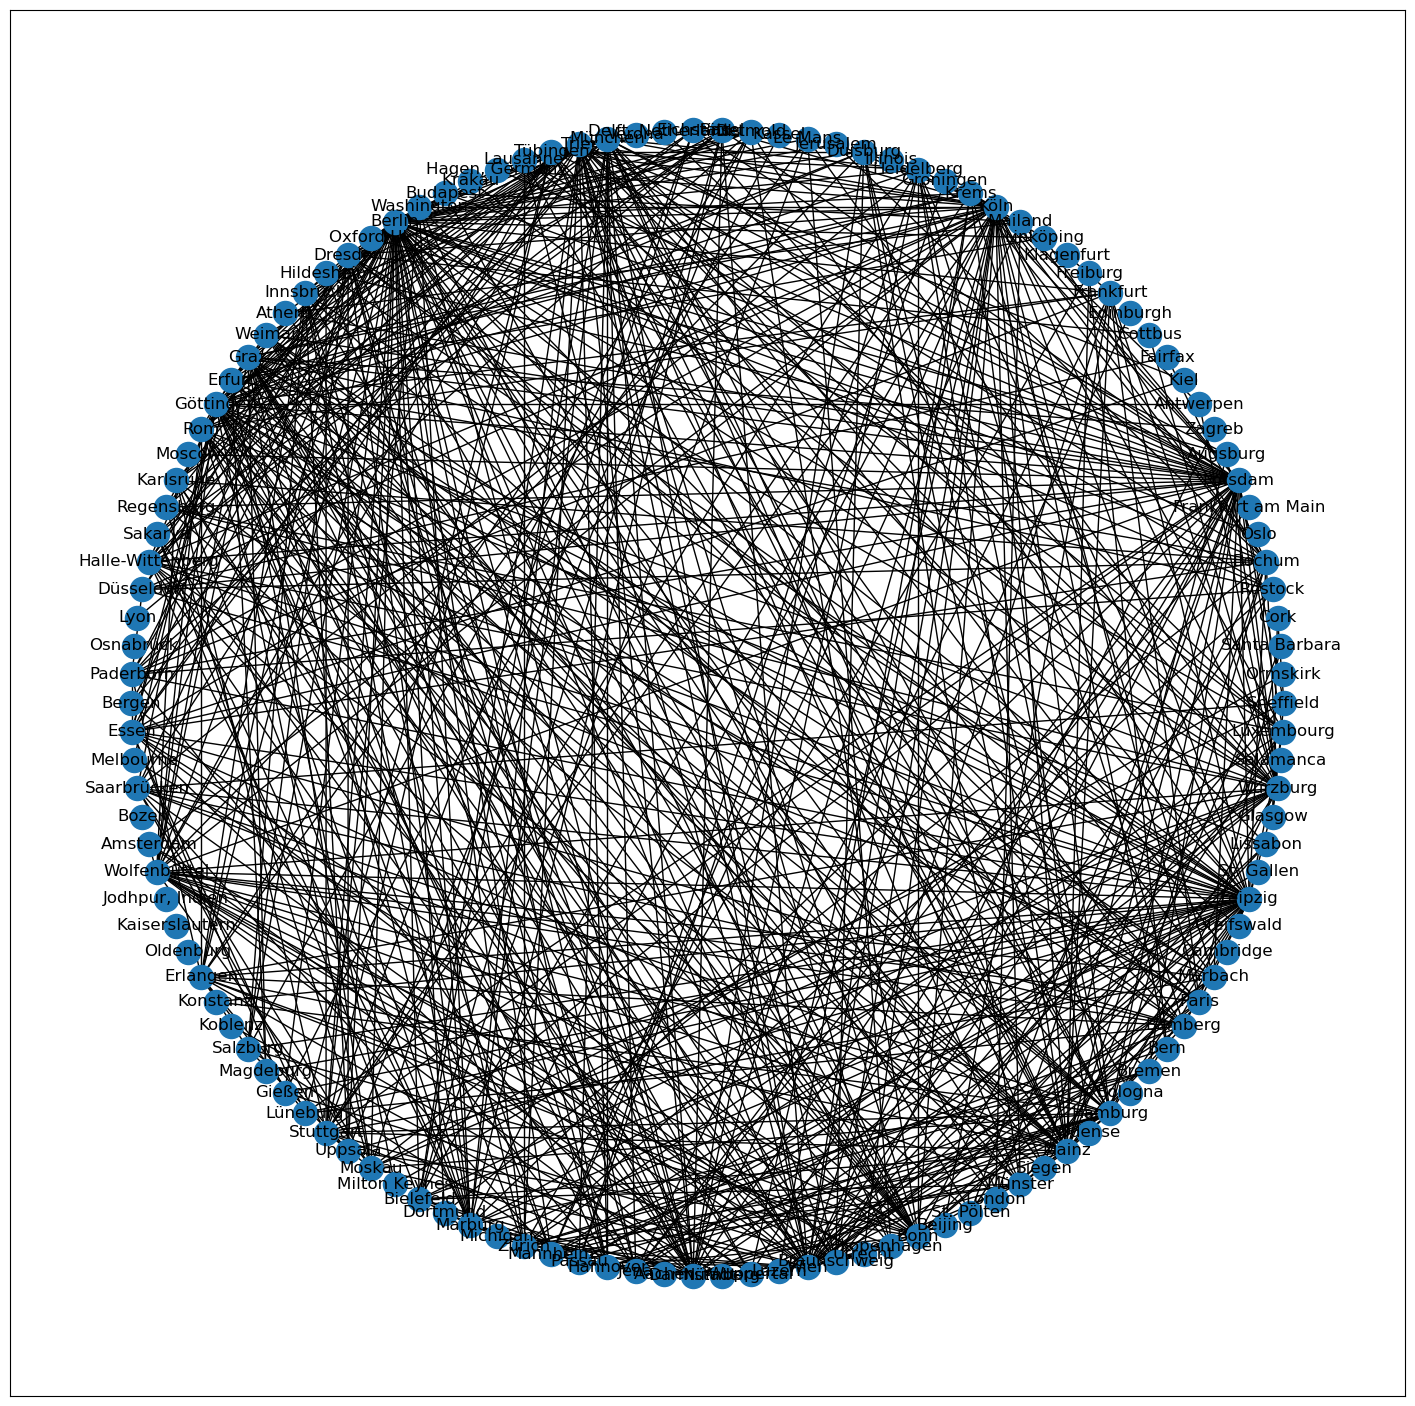

In [17]:
import matplotlib.pyplot as plt
pos = nx.circular_layout(G)
plt.figure(3,figsize=(18,18)) 
nx.draw_networkx(G, pos=pos,node_color="tab:blue")

for edge in G.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=(edge[2]/250), alpha = (edge[2]/150))

# GeoPandas

In [18]:
import geopandas as gpd#
from geopy import geocoders  
from geodatasets import get_path
from matplotlib import pyplot as plt

#### Connect cities to the topics and present the top 3 keywords for publications with at least on author from a city.

In [19]:
cityfreq = data.cities.map(lambda x: list(set(x))).explode().value_counts().to_frame().reset_index()
_tmp = data[data.topics.map(lambda x: (x is not None) and (x != ['']))].copy()
citytopics = pd.DataFrame(sum(_tmp[["year", "cities", "topics"]].apply(lambda x: [(x["year"],c,t)  for t in x["topics"]  for c in set(x["cities"])] if x["topics"] != []else [] , axis=1),[]),
            columns=["year", "city", "topic"])
city_to_keyword_dict = citytopics.groupby(["city"]).topic.agg(lambda x: ";".join(x.value_counts().index[x.value_counts()>0][:3]))
city_to_keyword_dict = city_to_keyword_dict.to_frame().reset_index()
city_to_keyword_dict
cityfreq.columns = ["city", "count"]
cityfreq = cityfreq.merge(city_to_keyword_dict)
cityfreq

city  count  \
0               Berlin    155   
1                 Wien     89   
2             Würzburg     85   
3                 Köln     81   
4            Göttingen     70   
5              Hamburg     68   
6            Stuttgart     62   
7              Leipzig     62   
8                 Graz     62   
9              Potsdam     58   
10           Darmstadt     57   
11             München     49   
12               Mainz     47   
13               Trier     44   
14           Paderborn     34   
15           Frankfurt     33   
16        Wolfenbüttel     30   
17            Erlangen     29   
18          Heidelberg     26   
19             Dresden     25   
20          Regensburg     25   
21    Halle-Wittenberg     23   
22                Bonn     22   
23            Mannheim     20   
24             Marburg     20   
25            Tübingen     20   
26                Jena     17   
27              Passau     17   
28              Bochum     17   
29              Zürich     16   
30           Karlsruhe     15   
31               Essen     14   
32             Bamberg     13   
33           Wuppertal     13   
34              Moskau     13   
35               Paris     12   
36               Krems     12   
37             Münster     12   
38           Bielefeld     10   
39               Basel     10   
40             Marbach     10   
41              Gießen      9   
42           Innsbruck      9   
43         Saarbrücken      9   
44          Hildesheim      8   
45          Luxembourg      8   
46        Braunschweig      8   
47                 Rom      8   
48            Hannover      8   
49             Detmold      7   
50             Rostock      7   
51              Weimar      7   
52              Erfurt      6   
53                Bern      6   
54            Salzburg      6   
55          Düsseldorf      6   
56            Dortmund      5   
57             Le Mans      5   
58            Nürnberg      5   
59            Freiburg      5   
60              Bergen      5   
61            Lüneburg      5   
62            Duisburg      5   
63            Lausanne      4   
64              Siegen      4   
65          Washington      4   
66            Konstanz      3   
67      Hagen, Germany      3   
68              Aachen      3   
69           Sheffield      3   
70           Eichstätt      3   
71              Kassel      3   
72             Cottbus      3   
73              Bremen      3   
74          St. Gallen      2   
75                Kiel      2   
76            Michigan      2   
77       Milton Keynes      2   
78           Cambridge      2   
79          Kopenhagen      2   
80           Amsterdam      2   
81           Antwerpen      2   
82             Mailand      2   
83           Salamanca      2   
84              London      1   
85            Budapest      1   
86             Koblenz      1   
87              Zagreb      1   
88              Athens      1   
89   Frankfurt am Main      1   
90                Cork      1   
91               Bozen      1   
92           Oxford Uk      1   
93           Jerusalem      1   
94            Ormskirk      1   
95       Santa Barbara      1   
96             Glasgow      1   
97             Fairfax      1   
98           Melbourne      1   
99          Greifswald      1   
100             Verona      1   
101     Kaiserslautern      1   
102           Augsburg      1   
103            Uppsala      1   
104          Groningen      1   
105         St. Pölten      1   
106         Klagenfurt      1   
107           Lissabon      1   
108               Lyon      1   
109            Bologna      1   
110               Oslo      1   
111          Osnabrück      1   
112            Utrecht      1   
113          Edinburgh      1   
114             Krakau      1   
115             Moscow      1   
116             Odense      1   

                                                      topic  
0                    Annotieren;Visualisierung;Modellierung  

##### To retrieve the GeoNames make an account here http://www.geonames.org/login
##### https://geocoder.readthedocs.io/providers/GeoNames.html

In [21]:
gn = geocoders.GeoNames("your user name")

In [22]:
geocodes = cityfreq.city.map(gn.geocode)

In [23]:
geocodes[geocodes.isna()]

Series([], Name: city, dtype: object)

In [24]:
geocoded_cities = pd.DataFrame([(x[0],x[1][0], x[1][1] ) if x is not None else (None, None, None,) for x in geocodes],
            columns = ["location", "latitude", "longitude"])
df = pd.concat([cityfreq,geocoded_cities], axis=1)
df

city  count  \
0               Berlin    155   
1                 Wien     89   
2             Würzburg     85   
3                 Köln     81   
4            Göttingen     70   
5              Hamburg     68   
6            Stuttgart     62   
7              Leipzig     62   
8                 Graz     62   
9              Potsdam     58   
10           Darmstadt     57   
11             München     49   
12               Mainz     47   
13               Trier     44   
14           Paderborn     34   
15           Frankfurt     33   
16        Wolfenbüttel     30   
17            Erlangen     29   
18          Heidelberg     26   
19             Dresden     25   
20          Regensburg     25   
21    Halle-Wittenberg     23   
22                Bonn     22   
23            Mannheim     20   
24             Marburg     20   
25            Tübingen     20   
26                Jena     17   
27              Passau     17   
28              Bochum     17   
29              Zürich     16   
30           Karlsruhe     15   
31               Essen     14   
32             Bamberg     13   
33           Wuppertal     13   
34              Moskau     13   
35               Paris     12   
36               Krems     12   
37             Münster     12   
38           Bielefeld     10   
39               Basel     10   
40             Marbach     10   
41              Gießen      9   
42           Innsbruck      9   
43         Saarbrücken      9   
44          Hildesheim      8   
45          Luxembourg      8   
46        Braunschweig      8   
47                 Rom      8   
48            Hannover      8   
49             Detmold      7   
50             Rostock      7   
51              Weimar      7   
52              Erfurt      6   
53                Bern      6   
54            Salzburg      6   
55          Düsseldorf      6   
56            Dortmund      5   
57             Le Mans      5   
58            Nürnberg      5   
59            Freiburg      5   
60              Bergen      5   
61            Lüneburg      5   
62            Duisburg      5   
63            Lausanne      4   
64              Siegen      4   
65          Washington      4   
66            Konstanz      3   
67      Hagen, Germany      3   
68              Aachen      3   
69           Sheffield      3   
70           Eichstätt      3   
71              Kassel      3   
72             Cottbus      3   
73              Bremen      3   
74          St. Gallen      2   
75                Kiel      2   
76            Michigan      2   
77       Milton Keynes      2   
78           Cambridge      2   
79          Kopenhagen      2   
80           Amsterdam      2   
81           Antwerpen      2   
82             Mailand      2   
83           Salamanca      2   
84              London      1   
85            Budapest      1   
86             Koblenz      1   
87              Zagreb      1   
88              Athens      1   
89   Frankfurt am Main      1   
90                Cork      1   
91               Bozen      1   
92           Oxford Uk      1   
93           Jerusalem      1   
94            Ormskirk      1   
95       Santa Barbara      1   
96             Glasgow      1   
97             Fairfax      1   
98           Melbourne      1   
99          Greifswald      1   
100             Verona      1   
101     Kaiserslautern      1   
102           Augsburg      1   
103            Uppsala      1   
104          Groningen      1   
105         St. Pölten      1   
106         Klagenfurt      1   
107           Lissabon      1   
108               Lyon      1   
109            Bologna      1   
110               Oslo      1   
111          Osnabrück      1   
112            Utrecht      1   
113          Edinburgh      1   
114             Krakau      1   
115             Moscow      1   
116             Odense      1   

                                                      topic  \
0                    Annotieren;Visualisierung;Modellierung 

In [25]:

gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)
gdf=gdf[~gdf.apply(lambda x: any(e is None for e in x), axis=1)]

In [26]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe =  world[world.name == "europe"]

/tmp/ipykernel_1625824/1223569970.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Interactive Map:
Markersize not proportional !!

In [27]:
gdf["bubble_size"] = gdf["count"].rank() / len(gdf) * 100
gdf.explore("count", tooltip=["city", "count", "topic"], 
            marker_type="circle_marker",
            marker_kwds={"radius":5})

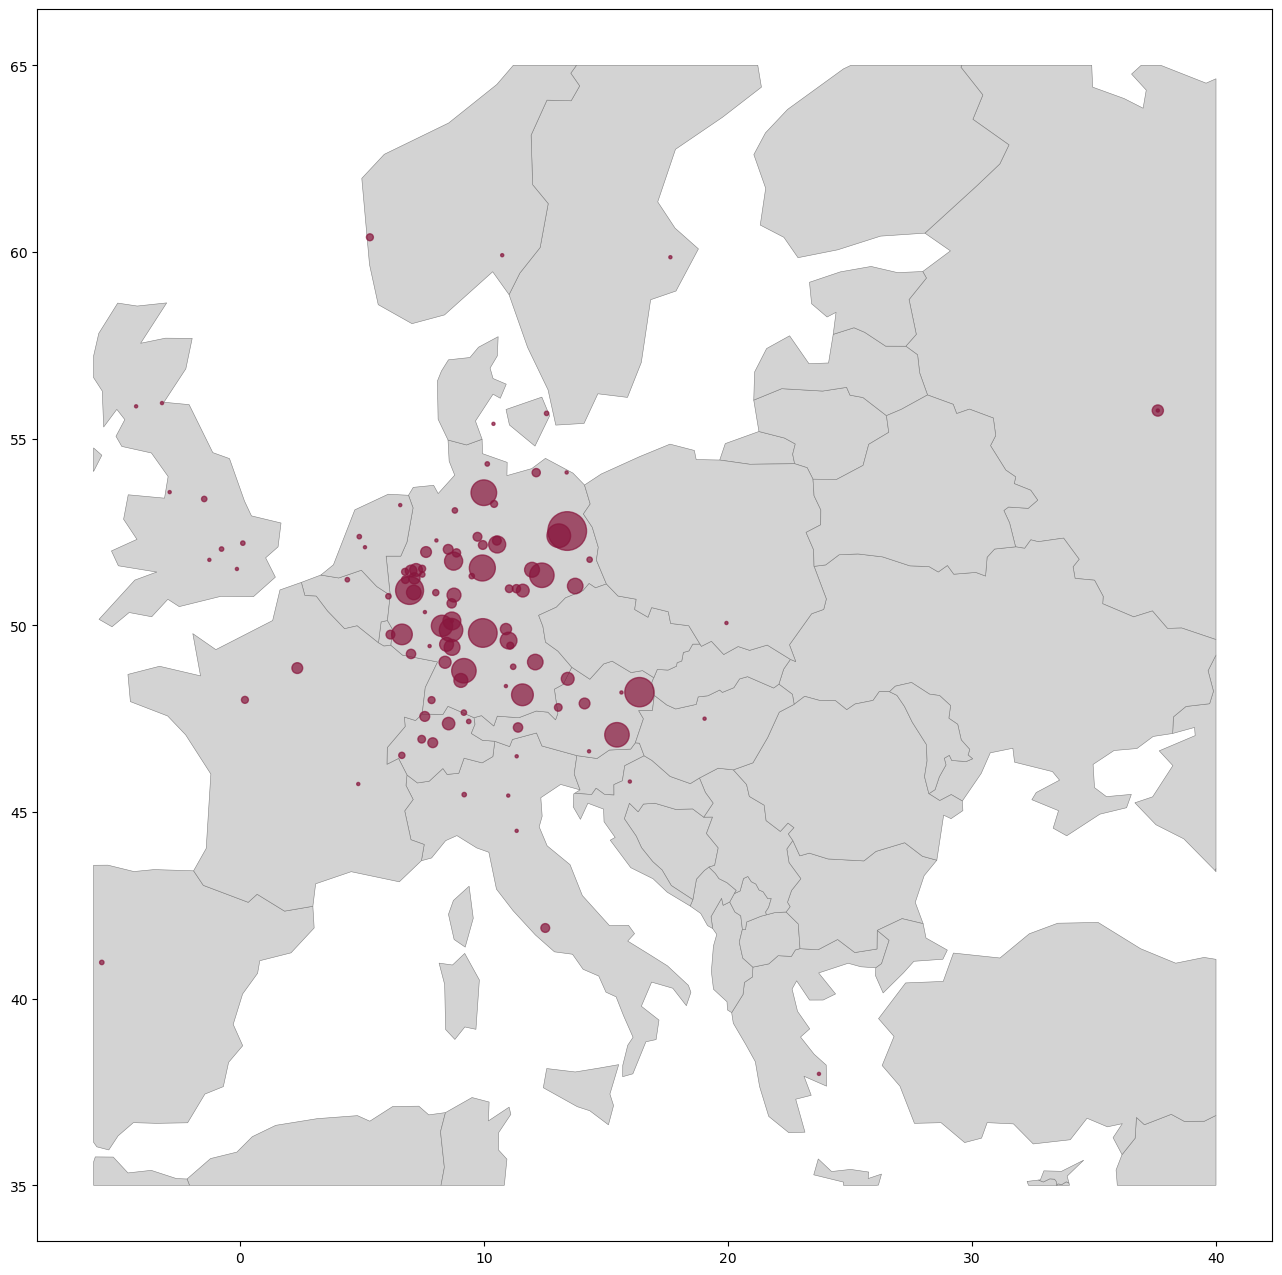

In [28]:
area = [-6, 35,40, 65]
_tmp = gdf.clip(area).copy()

fig, ax = plt.subplots(figsize=(16,16))
marker = _tmp['count']*5

ax = world.clip(area).plot(ax=ax, color="lightgray",edgecolor="grey", linewidth=0.4)
_tmp.plot(ax=ax,color="#88163d", markersize=marker,alpha=0.7, categorical=False,  legend=True )
plt.show()

In [29]:
import contextily as ctx
europe =  gpd.read_file("/home/jb/Downloads/NUTS_RG_01M_2021_4326.geojson")

['Österreich', 'Deutschland', 'Luxembourg', 'Schweiz/Suisse/Svizzera']


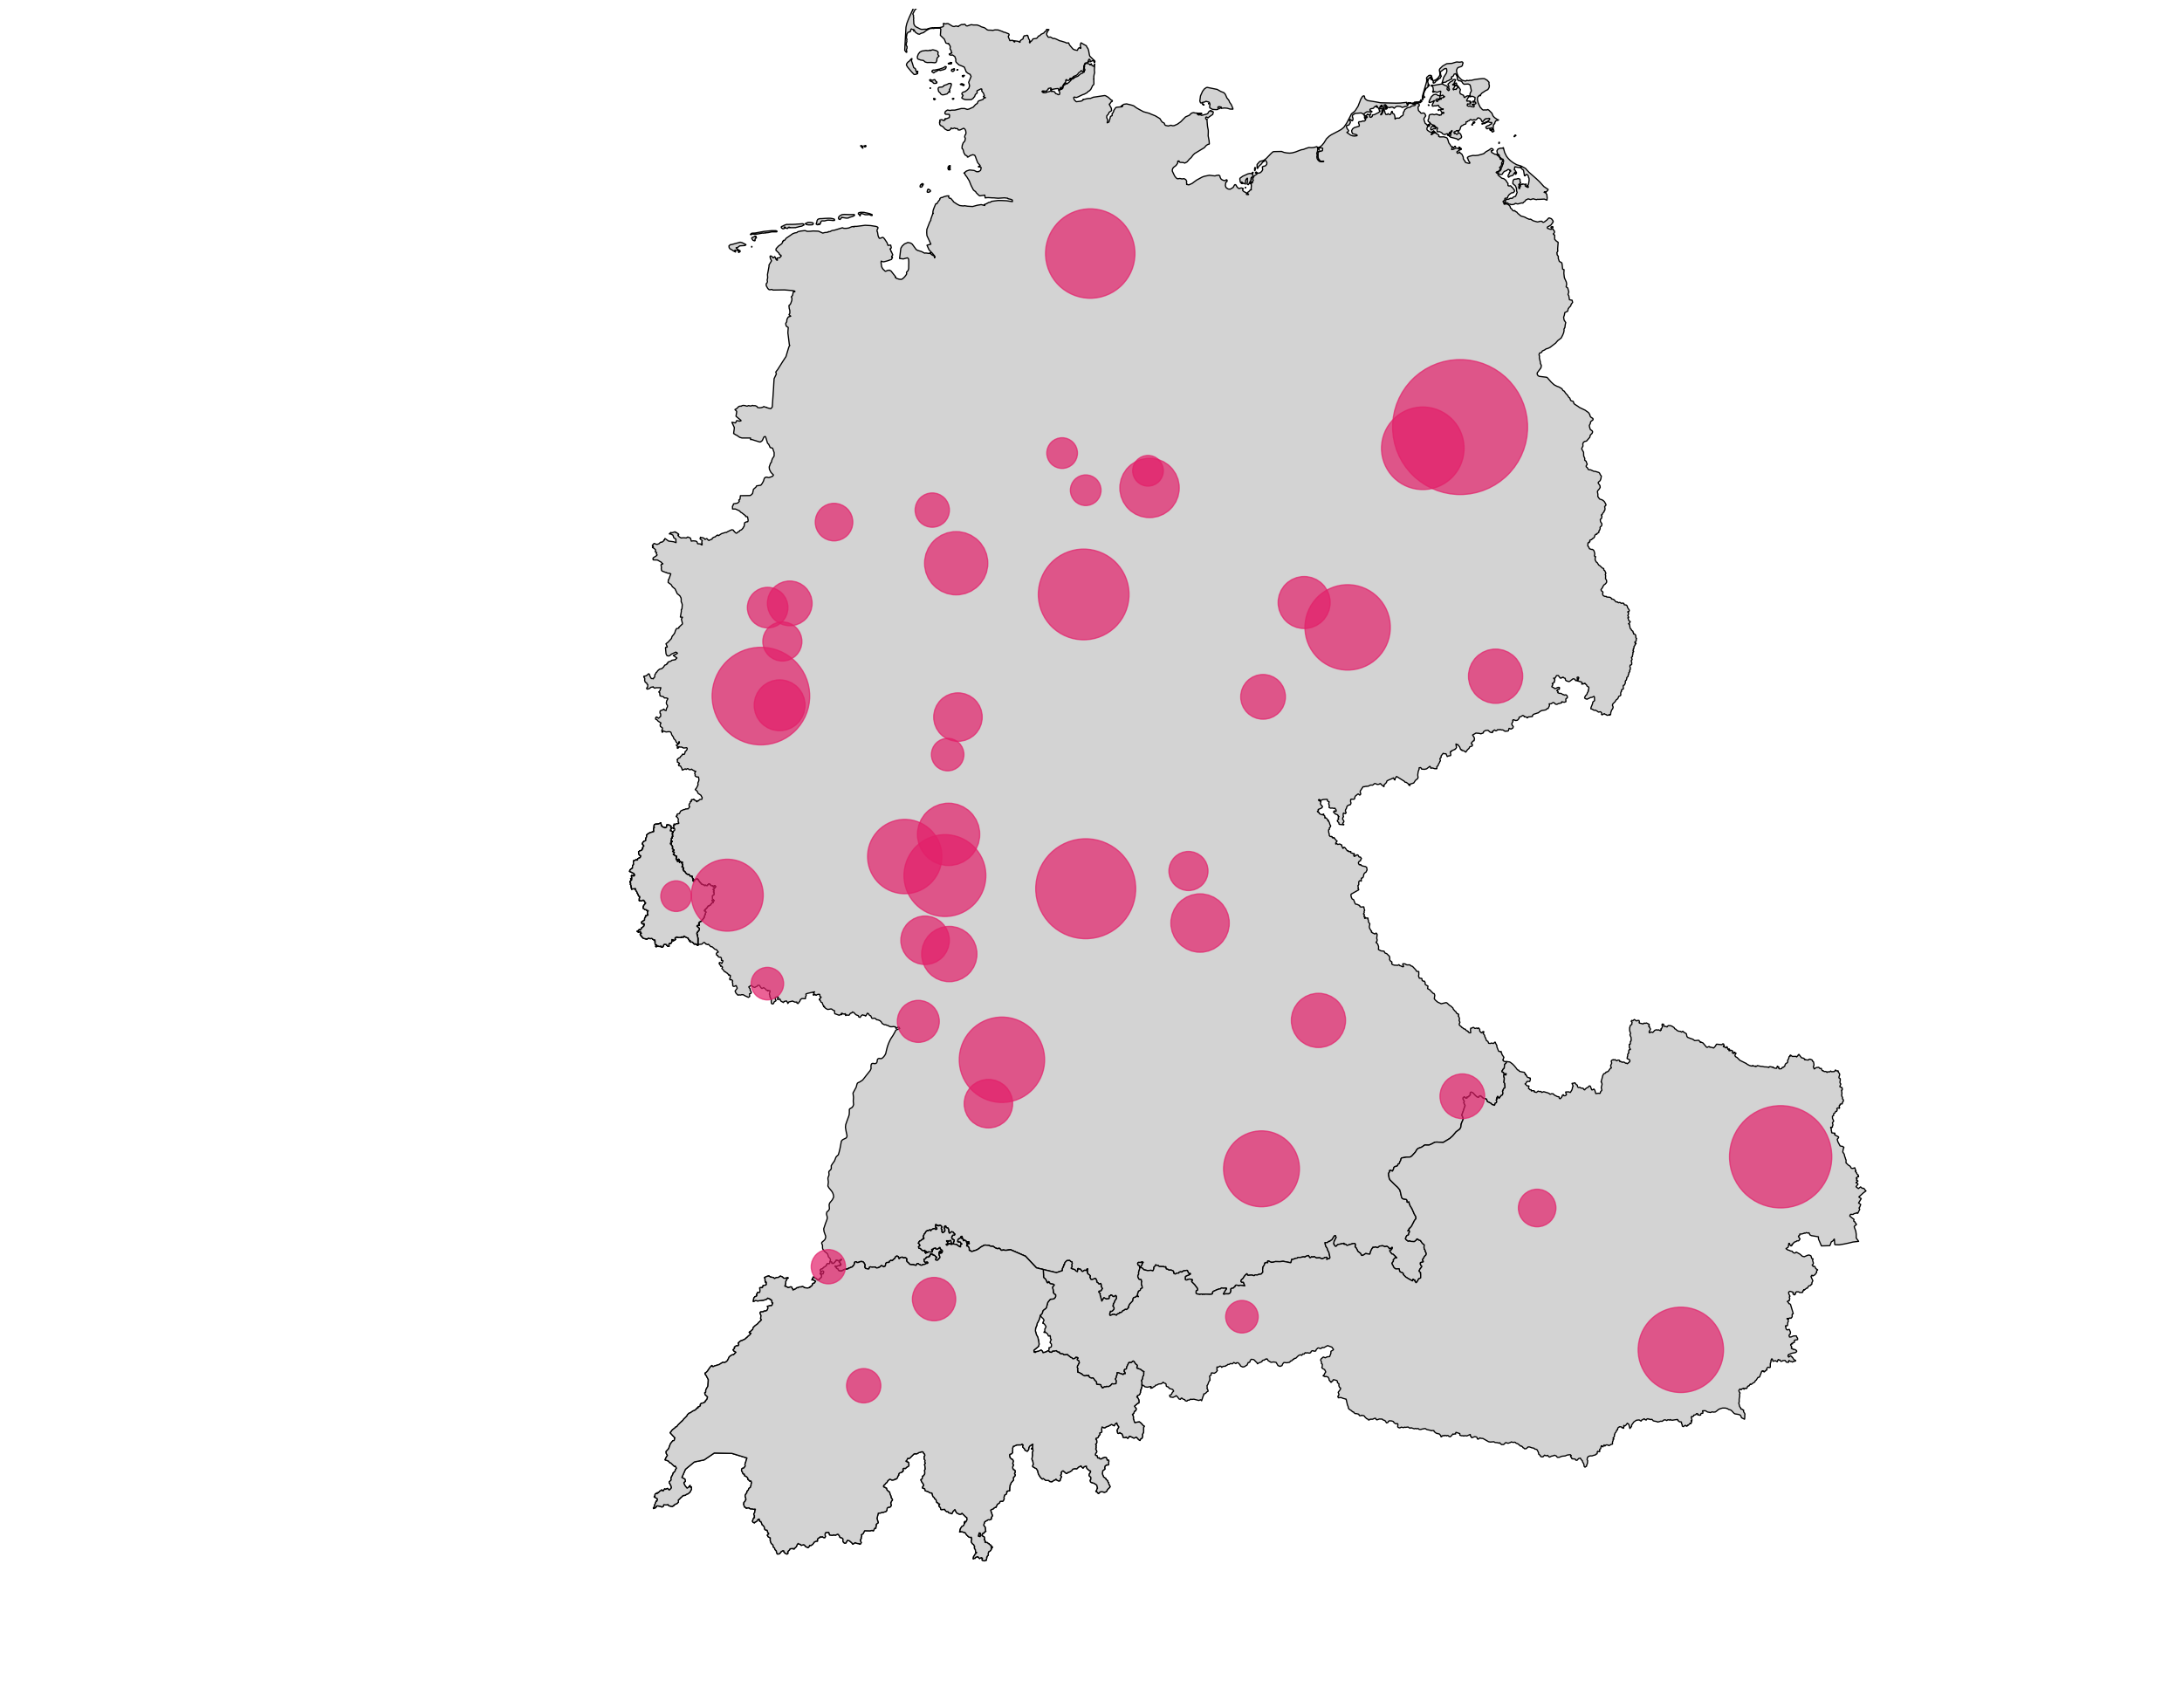

In [30]:
list_of_countries= set(x for x in gdf.location.map(lambda x: x.split(", ")[-1] if x is not None else "") if x != "")
list_of_country_codes=['AT',"DE", "LU", "CH"]
list_of_countries=['Österreich',"Deutschland", "Luxembourg", "Schweiz/Suisse/Svizzera"]

list_of_countriesf=['Austria',"Germany", "Luxembourg", "Switzerland"]
print(list_of_countries)
ax = europe[europe.CNTR_CODE.str.contains("|".join(list_of_country_codes)) & (europe.NUTS_NAME.str.contains("|".join(list_of_countries)))].plot(color="lightgray", figsize=(32,32), edgecolor="black")

_tmp = gdf[gdf.location.map(lambda x: any(l in x for l in list_of_countriesf)) & (gdf["count"]>=8)]
marker = _tmp['count']*80
ax = _tmp.plot(ax=ax,color="#e3206a", markersize=marker,alpha=0.7, categorical=False,  legend=True )
ax.axis([0, 20, 45, 55])
ax.axis("off")
plt.savefig("cityViz.svg")

In [31]:
europe.crs, gdf.crs


(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

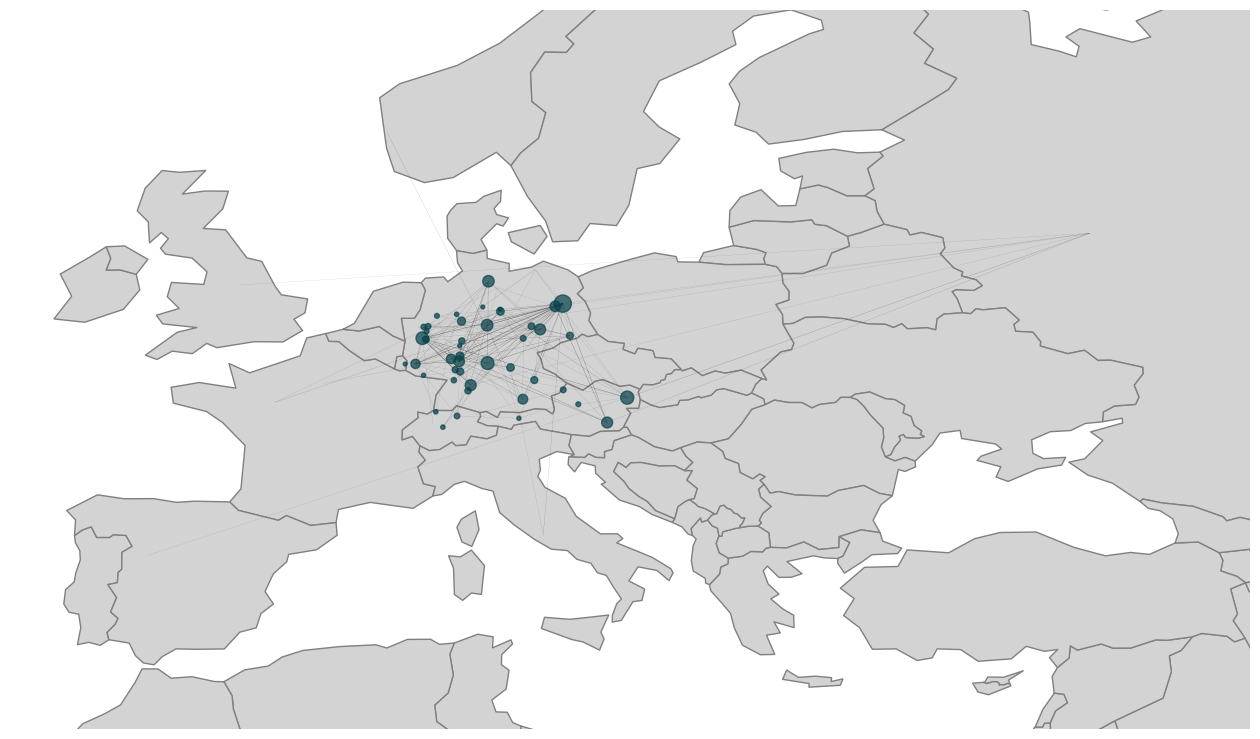

In [32]:
import numpy as np
european_regions = world

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx

sG = nx.Graph([ x for x in G.subgraph(gdf["city"].to_list()).edges(data=True) if x[2]["weight"] >1])
marker = [dict(zip(*_tmp[["city", "count"]].transpose().values)).get(n,0) for n in sG.nodes()]
positions = dict(zip(gdf["city"],gdf["geometry"].map(lambda x: [x.x,x.y])))

# plot with a nice basemap
ax = european_regions.plot(linewidth=1, edgecolor="grey", facecolor="lightgray", figsize=(16,16))
ax.axis([-12, 45, 33, 66])
ax.axis("off")
nx.draw(sG, positions, ax=ax, node_size=marker, node_color="#07424A", alpha=0.7, width=[x[2]["weight"]/40 for x in sG.edges(data=True)])
plt.show()

In [33]:
gdf.to_file('../results/geodata_publication.geojson')  